# Building AI Models to Predict the Price of Airbnb Listings

In practice, building a robust and accurate AI model requires a significant number of data pre-processing, feature engineering and encoding steps. It is not as straightforward as the basic models we have seen. In this notebook, let's attempt a real-world case of predicting the price of an Airbnb listing based on the features, rental history and other characteristics of the property. 

Airbnb does not release any data on the listings in its marketplace, but a separate group named [Inside Airbnb](http://insideairbnb.com/get-the-data.html) extracts and compiles publicly available information about Airbnb listings in capital cities across the world. For this project, we will be using Airbnb data for Sydney which was scraped on April 12, 2021. It contains information on all Sydney Airbnb listings that were live on the site on that date (+32,000).

Each row in the dataset is a property available for rent (listing) on Airbnb while the  columns describe the characteristics of each property (features).

## Installing libraries

In [1]:
# time series decomposition
!pip install stldecompose
!pip install statsmodels 

# Geographical analysis
!pip install geopandas

# xgboost package
!pip install xgboost 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.6 MB/s 
     |████████████████████████████████| 6.3 MB 44.0 MB/s 
     |████████████████████████████████| 16.7 MB 321 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing libraries

In [2]:
# the following two commands ignore warnings raised due to version updates.
import warnings
warnings.filterwarnings('ignore')

import pandas as pd # Used for data analysis and manipulation - data frames
import numpy as np # Used for scientific computing and efficient multi dimensional array processing

# access data from the hosted location on Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# time series decomposition
from stldecompose import decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# geographical analysis
import geopandas 
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import xgboost as xgb
from xgboost import plot_importance
import lightgbm as lgb
# from sklearn.model_selection import train_test_split, GridSearchCV

# performance evaluaters
from sklearn import metrics
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import sklearn.metrics as sm

# visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable

# Set plot preference
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

## Data Import

For convenience, a datset containing all Sydney Airbnb listings is hosted on Google drive, we need to complete the familiar authentication step to access this file (it is a large file ~60mb).

In [3]:
# Import libraries for reading the data file 
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# This is the file ID of the data set
dataset_file_id = '1ejzhW2WE70WW40vanK6e9hZZWjhCHvGs'

# Download the file from Google Drive
downloaded = drive.CreateFile({'id':dataset_file_id})
downloaded.GetContentFile('sydney_airbnb_listings.csv')

In [4]:
# Reading the data to Pandas dataframes
data_file = 'sydney_airbnb_listings.csv'
df_sydney_airbnb_listings = pd.read_csv(data_file) # Reading the data and storing to a dataframe

## Data exploration

### Description of relevant features


- `host_since` - date that the host first joined Airbnb

- `host_response_time` - average amount of time the host takes to reply to messages

- `host_response_rate` - proportion of messages that the host replies to

- `host_is_superhost` - whether or not the host is a superhost, which is a mark of quality for the top-rated and most experienced hosts, and can increase your search ranking on Airbnb

- `host_listings_count` - how many listings the host has in total

- `host_identity_verified` - whether or not the host has been verified with id

- `neighbourhood_cleansed` - the Sydney borough the property is in

- `property_type` - type of property, e.g. house or flat

- `room_type` - type of listing, e.g. entire home, private room or shared room

- `accommodates` - how many people the property accommodates

- `bathrooms` - number of bathrooms

- `bedrooms` - number of bedrooms

- `beds` - number of beds

- `bed_type` - type of bed, e.g. real bed or sofa-bed

- `amenities` - list of amenities

- `price` - nightly advertised price (the target variable)

- `minimum_nights` - the minimum length of stay

- `maximum_nights` - the maximum length of stay

- `calendar_updated` - when the host last updated the calendar

- `availability_30` - how many nights are available to be booked in the next 30 days

- `availability_60` - how many nights are available to be booked in the next 60 days

- `availability_90` - how many nights are available to be booked in the next 90 days

- `availability_365` - how many nights are available to be booked in the next 365 days

- `number_of_reviews` - the number of reviews left for the property

- `number_of_reviews_ltm` - the number of reviews left for the property in the last twelve months

- `first_review` - the date of the first review

- `last_review` - the date of the most recent review

- `review_scores_rating` - guests can score properties overall from 1 to 5 stars

- `review_scores_accuracy` - guests can score the accuracy of a property's description from 1 to 5 stars

- `review_scores_cleanliness` - guests can score a property's cleanliness from 1 to 5 stars

- `review_scores_checkin` - guests can score their check-in from 1 to 5 stars

- `review_scores_communication` - guests can score a host's communication from 1 to 5 stars

- `review_scores_location` - guests can score a property's location from 1 to 5 stars

- `review_scores_value` - guests can score a booking's value for money from 1 to 5 stars

- `instant_bookable` - whether or not the property can be instant booked (i.e. booked straight away, without having to message the host first and wait to be accepted)

- `cancellation_policy` - the type of cancellation policy, e.g. strict or moderate

- `reviews_per_month` - calculated field of the average number of reviews left by guest each month

In [5]:
# return a tuple representing the dimensionality of the dataframe i.e. (rows, columns)
df_sydney_airbnb_listings.shape

(32679, 74)

In [6]:
# View the top 5 rows of the df
df_sydney_airbnb_listings.head(5)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11156,https://www.airbnb.com/rooms/11156,20210410042103,2021-04-12,An Oasis in the City,Very central to the city which can be reached ...,"It is very close to everything and everywhere,...",https://a0.muscache.com/pictures/2797669/17895...,40855,https://www.airbnb.com/users/show/40855,...,10.0,10.0,10.0,NaN,f,1,0,1,0,1.42
1,12351,https://www.airbnb.com/rooms/12351,20210410042103,2021-04-15,Sydney City & Harbour at the door,Come stay with Vinh & Stuart (Awarded as one o...,"Pyrmont is an inner-city village of Sydney, on...",https://a0.muscache.com/pictures/763ad5c8-c951...,17061,https://www.airbnb.com/users/show/17061,...,10.0,10.0,10.0,NaN,f,2,0,2,0,4.03
2,14250,https://www.airbnb.com/rooms/14250,20210410042103,2021-04-14,Manly Harbour House,"Beautifully renovated, spacious and quiet, our...",Balgowlah Heights is one of the most prestigio...,https://a0.muscache.com/pictures/56935671/fdb8...,55948,https://www.airbnb.com/users/show/55948,...,8.0,9.0,8.0,NaN,f,2,2,0,0,0.03
3,15253,https://www.airbnb.com/rooms/15253,20210410042103,2021-04-12,Unique Designer Rooftop Apartment in City Loca...,Penthouse living at it best ... You will be st...,The location is really central and there is nu...,https://a0.muscache.com/pictures/46dcb8a1-5d5b...,59850,https://www.airbnb.com/users/show/59850,...,10.0,10.0,9.0,NaN,t,1,0,1,0,3.30
4,44545,https://www.airbnb.com/rooms/44545,20210410042103,2021-04-13,Sunny Darlinghurst Warehouse Apartment,Sunny warehouse/loft apartment in the heart of...,Darlinghurst is home to some of Sydney's best ...,https://a0.muscache.com/pictures/a88d8e14-4f63...,112237,https://www.airbnb.com/users/show/112237,...,10.0,10.0,10.0,NaN,f,1,1,0,0,0.60


In [7]:
# view data types of the columns along with the non-null count 
df_sydney_airbnb_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32679 entries, 0 to 32678
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            32679 non-null  int64  
 1   listing_url                                   32679 non-null  object 
 2   scrape_id                                     32679 non-null  int64  
 3   last_scraped                                  32679 non-null  object 
 4   name                                          32667 non-null  object 
 5   description                                   31442 non-null  object 
 6   neighborhood_overview                         19345 non-null  object 
 7   picture_url                                   32679 non-null  object 
 8   host_id                                       32679 non-null  int64  
 9   host_url                                      32679 non-null 

In [8]:
# computes a summary of statistics pertaining to the numerical features.
df_sydney_airbnb_listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,3.267900e+04,3.267900e+04,3.267900e+04,31702.000000,31702.000000,0.0,32679.000000,32679.000000,32679.000000,0.0,...,21801.000000,21824.000000,21802.000000,21794.000000,0.0,32679.000000,32679.000000,32679.000000,32679.000000,23070.000000
mean,2.562552e+07,2.021041e+13,9.612570e+07,67.954356,67.954356,NaN,-33.862144,151.200187,3.253466,NaN,...,9.709967,9.705004,9.695349,9.319813,NaN,7.732275,5.390434,2.232718,0.055479,0.636133
std,1.337994e+07,6.367285e+00,9.774168e+07,680.612307,680.612307,NaN,0.075142,0.089841,2.137005,NaN,...,0.885332,0.917402,0.783485,1.109044,NaN,28.852122,20.803546,14.647191,0.554415,1.129832
min,1.115600e+04,2.021041e+13,1.085700e+04,0.000000,0.000000,NaN,-34.135590,150.602050,1.000000,NaN,...,2.000000,2.000000,2.000000,2.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.510028e+07,2.021041e+13,1.994384e+07,1.000000,1.000000,NaN,-33.900010,151.175700,2.000000,NaN,...,10.000000,10.000000,10.000000,9.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.060000
50%,2.431235e+07,2.021041e+13,5.297556e+07,1.000000,1.000000,NaN,-33.882600,151.215210,2.000000,NaN,...,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.000000,0.000000,0.000000,0.180000
75%,3.808761e+07,2.021041e+13,1.551981e+08,2.000000,2.000000,NaN,-33.826965,151.260825,4.000000,NaN,...,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,1.000000,1.000000,0.000000,0.757500
max,4.912045e+07,2.021041e+13,3.960200e+08,7755.000000,7755.000000,NaN,-33.399900,151.340410,16.000000,NaN,...,10.000000,10.000000,10.000000,10.000000,NaN,246.000000,194.000000,162.000000,17.000000,52.270000


## Data cleaning and pre-processing



### 1. Delete NaN columns

NaN - "not a number"

In [9]:
# drop NaN columns in the dataframe
df_sydney_airbnb_listings = df_sydney_airbnb_listings.dropna(axis=1, how="all", thresh=None, subset=None, inplace=False)

### 2. Delete text columns

As Natural Language Processing (NLP) will not be used in the creation of this model, free text columns will be dropped. Other columns which are not useful for predicting price (e.g. url, host name and other host-related features that are unrelated to the property) will be also dropped in this pre-processing step.

In [10]:
# specifying the text columns to drop from the dataframe
cols_to_drop = ['listing_url','scrape_id','last_scraped','description','neighborhood_overview','picture_url','host_id','host_url','host_name','host_location','host_about',
                'host_thumbnail_url','host_picture_url','host_neighbourhood','host_verifications','calendar_last_scraped','host_acceptance_rate','host_has_profile_pic']

# drop the specified columns
df_sydney_airbnb_listings = df_sydney_airbnb_listings.drop(cols_to_drop, axis=1)

### 3. Delete other duplicate/erroneous columns

`host_listings_count` and `host_total_listings_count` are the same in all but 977 out of 32679 cases. These cases are those where the value is `NaN`. Therefore one of these columns can be dropped. Other columns which split these into type of property will also be dropped, as they will be highly correlated (one will be the total of the others).

In [11]:
# find the duplicate/erroneous columns
print(sum((df_sydney_airbnb_listings.host_listings_count == df_sydney_airbnb_listings.host_total_listings_count) == False))
df_sydney_airbnb_listings.loc[((df_sydney_airbnb_listings.host_listings_count == df_sydney_airbnb_listings.host_total_listings_count) == False)][:3]

977


,id,name,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
72,340563,Resort Style minutes from the City,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,10.0,10.0,9.0,f,1,0,1,0,0.08
87,377711,"Art-deco Flat, Leafy & Beachside",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,10.0,10.0,10.0,f,2,1,1,0,0.34
101,418136,Sunny Private Unit near Manly Beach,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Sydney, New South Wales, Australia",...,10.0,10.0,9.0,9.0,f,1,1,0,0,0.49


In [12]:
# Deleting the correlated columns
df_sydney_airbnb_listings.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
                                'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

There are multiple columns for property location, including an attempt by the site that originally scraped the data to clean up the neighbourhood locations. Some of these columns such as `latitude` and `longitude` can be deleted.

In [13]:
#delete lat/long
df_sydney_airbnb_listings.drop(['latitude','longitude'], axis=1, inplace=True)

There are multiple columns for minimum and maximum night stays. For example between the variables `minimum_nights` and `minimum_minimum_nights` most of the values presumably have similar values.

In [14]:
#find similar columns
sum((df_sydney_airbnb_listings.minimum_nights == df_sydney_airbnb_listings.minimum_minimum_nights) == False)

1148

In [15]:
# delete similar columns
df_sydney_airbnb_listings.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 
                                'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

### Encoding categorical into numerical



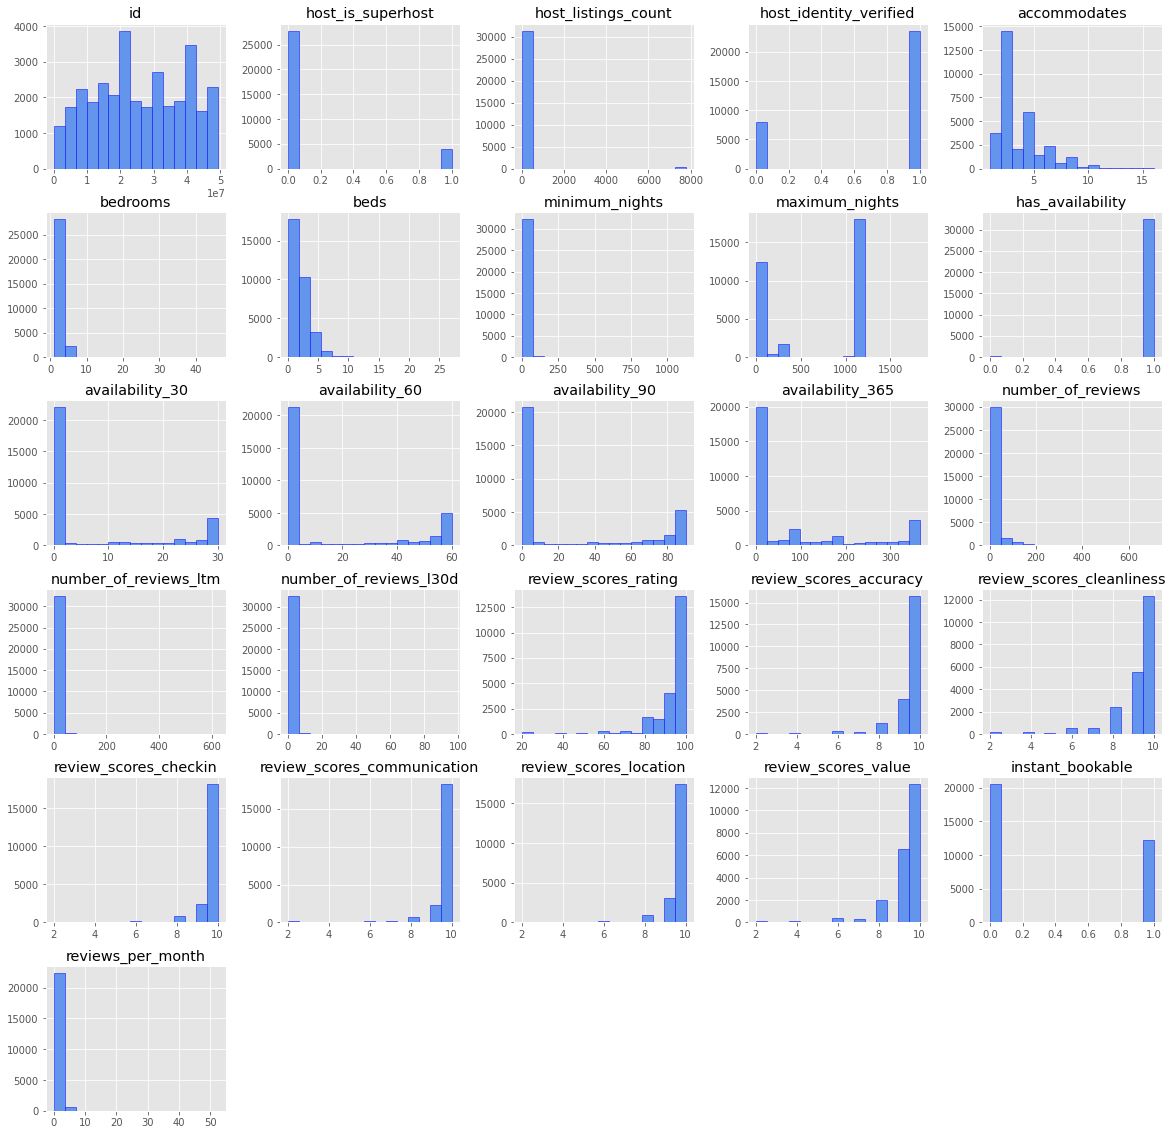

In [16]:
# Replacing columns with f/t with 0/1 to convert to a numerical output
df_sydney_airbnb_listings.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories through a histogram
df_sydney_airbnb_listings.hist(figsize=(20,20), bins=15, color = "cornflowerblue", ec='blue');

#### `host_since`

This is a datetime column, and will be converted into a measure of the number of days that a host has been on the platform, measured from the date that the data was collected (12 April, 2021). The resulting column will be referred to as `host_active_period`. The original column will be left in initially for the exploratory analysis, and dropped later.

In [17]:
# Converting to datetime
df_sydney_airbnb_listings.host_since = pd.to_datetime(df_sydney_airbnb_listings.host_since) 

# Calculating the number of days
df_sydney_airbnb_listings['host_active_period'] = (pd.datetime(2021, 4, 12) - df_sydney_airbnb_listings.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean active days as host:", round(df_sydney_airbnb_listings['host_active_period'].mean(),0))
print("Median active days as host:", df_sydney_airbnb_listings['host_active_period'].median())

# Replacing null values with the mean
df_sydney_airbnb_listings.host_active_period.fillna(df_sydney_airbnb_listings.host_active_period.mean(), inplace=True)

Mean active days as host: 1873.0
Median active days as host: 1925.0


#### `host_response_time`

Around two thirds of rows don't have a value for `host_response_time`. Therefore, this section of the data set consists primarily of properties which have not yet had a completed stay (assuming that most likely properties which have not yet had a booking, although may also include properties that have a booking currently occurring). 

Although this is a considerable proportion of the dataset, these listings will be retained in the data because they are still legitimate properties with advertised prices and are still part of the comparative market when considering the price for which to advertise your Airbnb listing. However, if the dataset being used had the actual average price paid as its target, it would be necessary to drop these rows because they would not have a value, as they have not yet been booked.

It is worth noting, however, that this group of listings probably also contains a large number of 'inactive' listings. These are properties which have been speculatively listed on Airbnb but either have their calendars closed (so no stays can be booked) or have prices which are notably higher than other properties in their area. Because `host_response_time` is unknown for so many listings, it will be retained as its own category, `'unknown'`.

In [18]:
print("Null values:", df_sydney_airbnb_listings.host_response_time.isna().sum())
print(f"Proportion: {round((df_sydney_airbnb_listings.host_response_time.isna().sum()/len(df_sydney_airbnb_listings))*100, 1)}%")

# Number of rows without a value for host_response_time which have also not yet had a review
unknown_response_time = len(df_sydney_airbnb_listings[df_sydney_airbnb_listings.loc[ :,['host_response_time', 'first_review']].isnull().sum(axis=1) == 2])
print("{} Airbnb listings are without a value for host response time and also had no review".format(unknown_response_time))

Null values: 20901
Proportion: 64.0%
7070 Airbnb listings are without a value for host response time and also had no review


In [19]:
df_sydney_airbnb_listings.host_response_time.fillna("unknown", inplace=True)
df_sydney_airbnb_listings.host_response_time.value_counts(normalize=True)

unknown               0.639585
within an hour        0.208605
within a few hours    0.060161
within a day          0.059121
a few days or more    0.032529
Name: host_response_time, dtype: float64

#### `host_response_rate`

The same applies to *host_response_rate*, where about two thirds of values are null. This will also be kept as its own category, after grouping other values into meaningful groups (i.e. transforming this into a categorical feature, rather than a numerical one). Because about 75% of hosts respond 100% of the time, this will be kept as its own category, and other values will be grouped into bins.

In [20]:
print("Null values:", df_sydney_airbnb_listings.host_response_rate.isna().sum())
print(f"Proportion: {round((df_sydney_airbnb_listings.host_response_rate.isna().sum()/len(df_sydney_airbnb_listings))*100, 1)}%")

Null values: 20901
Proportion: 64.0%


In [21]:
# Removing the % sign from the host_response_rate string and converting to an integer
df_sydney_airbnb_listings.host_response_rate = df_sydney_airbnb_listings.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df_sydney_airbnb_listings['host_response_rate'].mean(),0))
print("Median host response rate:", df_sydney_airbnb_listings['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df_sydney_airbnb_listings.host_response_rate == 100.0).sum()/df_sydney_airbnb_listings.host_response_rate.count())*100,1)}%")

Mean host response rate: 88.0
Median host response rate: 100.0
Proportion of 100% host response rates: 68.6%


In [22]:
# Bin into four categories
df_sydney_airbnb_listings.host_response_rate = pd.cut(df_sydney_airbnb_listings.host_response_rate, 
                               bins=[0, 50, 90, 99, 100], 
                               labels=['0-49%', '50-89%', '90-99%', '100%'], 
                               include_lowest=True)

# Converting to string
df_sydney_airbnb_listings.host_response_rate = df_sydney_airbnb_listings.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df_sydney_airbnb_listings.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df_sydney_airbnb_listings.host_response_rate.value_counts()

unknown    20901
100%        8084
50-89%      1348
0-49%       1279
90-99%      1067
Name: host_response_rate, dtype: int64

#### `host_is_superhost` 

There are 977 rows lacking values for each of five different host-related features. As this represents only 3% of the dataset, these rows will be dropped.

In [23]:
# Number of rows without a value for multiple host-related columns
no_val_host_columns = len(df_sydney_airbnb_listings[df_sydney_airbnb_listings.loc[ :, ['host_since', 'host_is_superhost', 
                                                                                       'host_listings_count', 'host_identity_verified']].isnull().sum(axis=1) == 4])
print("Number of rows without a value for multiple host-related columns: {}".format(no_val_host_columns))

# Dropping the rows without a value for multiple host-related columns
df_sydney_airbnb_listings.dropna(subset=['host_since'], inplace=True)

Number of rows without a value for multiple host-related columns: 977


#### `property_type`

Further encoding of property types is required as there are a large number of categories with only a few listings.

In [24]:
# Obtain a count of different property types in the Airbnb listing 
pd.DataFrame(df_sydney_airbnb_listings['property_type'].value_counts()).head(10)

,property_type
Entire apartment,11999
Private room in apartment,5864
Entire house,4588
Private room in house,3830
Private room in townhouse,677
Entire townhouse,555
Entire guest suite,533
Entire guesthouse,383
Shared room in apartment,338
Entire condominium,307


In [25]:
# extracting the top 7 prominent property types and replace the other categories with 'Other'
df_sydney_airbnb_listings.loc[~df_sydney_airbnb_listings.property_type.isin(['Entire apartment',
                                                                             'Private room in apartment',
                                                                             'Entire house',
                                                                             'Private room in house', 
                                                                             'Private room in townhouse',
                                                                             'Entire townhouse',
                                                                             'Entire guest suite']), 'property_type'] = 'Other'

#### `bathrooms`, `bedrooms` and `beds`


Check for the number of missing values pertaining to these 3 variables.

In [26]:
print("Null values bathrooms:", df_sydney_airbnb_listings.bathrooms_text.isna().sum())
print("Null values bedrooms:", df_sydney_airbnb_listings.bedrooms.isna().sum())
print("Null values beds:", df_sydney_airbnb_listings.beds.isna().sum())

Null values bathrooms: 30
Null values bedrooms: 2080
Null values beds: 400


 `bathrooms_text` is a text column, hence converting it to a numerical column

In [27]:
# Extract the numerical value and rename the column
df_sydney_airbnb_listings['bathrooms_text'] = df_sydney_airbnb_listings.bathrooms_text.str.extract('(\d+)')
df_sydney_airbnb_listings = df_sydney_airbnb_listings.rename(columns={"bathrooms_text": "bathrooms"})

# Convert the data column to a numeric column
df_sydney_airbnb_listings["bathrooms"] = pd.to_numeric(df_sydney_airbnb_listings["bathrooms"])

As the number of null values for the columns `bathrooms`, `bedrooms` and `beds`, are considerably a small, these missing values will be replaced with the median.

In [28]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    df_sydney_airbnb_listings[col].fillna(df_sydney_airbnb_listings[col].median(), inplace=True)

#### `amenities`

Amenities is a list of additional features in the property, i.e. whether it has a TV or parking which will be a crucial factor as well. Examples are below:

In [29]:
# Example of amenities listed for the first 5 listings
df_sydney_airbnb_listings.amenities[:5].values

array(['["Dishwasher", "Backyard", "Kitchen", "Shower gel", "Cooking basics", "Hair dryer", "Bed linens", "Oven", "Stove", "Elevator", "Single level home", "Extra pillows and blankets", "Fire extinguisher", "Smoke alarm", "Hangers", "Microwave", "Heating", "Washer", "Shampoo", "Essentials", "Iron", "Long term stays allowed", "Hot water", "Refrigerator", "Wifi", "Dishes and silverware", "Patio or balcony", "TV"]',
       '["Microwave", "Patio or balcony", "Wifi", "Dishes and silverware", "Shampoo", "Coffee maker", "TV", "Host greets you", "Iron", "Stove", "Dedicated workspace", "Smoke alarm", "Private entrance", "Lock on bedroom door", "Hot water", "Breakfast", "Fire extinguisher", "Heating", "Backyard", "Hangers", "Cooking basics", "Paid parking off premises", "Carbon monoxide alarm", "Essentials", "Kitchen", "Refrigerator", "Dishwasher", "Oven", "Air conditioning", "First aid kit", "Hair dryer"]',
       '["Stove", "Dedicated workspace", "Iron", "Patio or balcony", "Heating", "Hair dr

In [30]:
# Creating a set of all possible amenities
amenities_list = list(df_sydney_airbnb_listings.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace(']', ',')
amenities_list_string = amenities_list_string.replace('[', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set;

In the list above, some amenities are more important than others (i.e. a balcony is more likely to increase price than a fax machine), and some are likely to be fairly uncommon (i.e.. 'Electric profiling bed'). For this notebook, amenities will be extracted based on quick research into which amenities are considered by guests a selection of the more important as well as personal experience. These will be further investigated in the EDA section. For example, if it turns out that almost all properties have/do not have a particular amenity, that feature will not be very useful in helping explain differences in prices.

The amenities chosen are (multiple options indicate categories that can be combined):

- Air conditioning/central air conditioning
- TV/Amazon Echo/Apple TV/DVD player/game console/Netflix/projector and screen/smart TV
- BBQ grill/fire pit/propane barbeque
- Balcony/patio or balcony
- Beach view/beachfront/lake access/mountain view/ski-in ski-out/waterfront (i.e. great location/views)
- Bed linens
- Breakfast
- Coffee maker/espresso machine
- Cooking basics
- Dishwasher/Dryer/Washer/Washer and dryer
- Elevator
- Exercise equipment/gym/private gym/shared gym
- Family/kid friendly, or anything containing 'children'
- Free parking on premises/free street parking/outdoor parking/paid parking off premises/paid parking on premises
- Garden or backyard/outdoor seating/sun loungers/terrace
- Hot tub/jetted tub/private hot tub/sauna/shared hot tub/pool/private pool/shared pool
- Internet/pocket wifi/wifi
- Long term stays allowed
- Outdoor activities
- Pets allowed/cat(s)/dog(s)/pets live on this property/other pet(s)
- Private entrance
- Safe/security system
- Self check-in
- Smoking allowed
- Step-free access/wheelchair accessible, or anything containing 'accessible'
- Suitable for events

In [31]:
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV|Home theatre|Game console|Game|game|TV|tv'), 'electronics_and_entertainment'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('BBQ grill|Fire pit|barbeque'), 'bbq'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Beach view|Beachfront|Beach|Lake access|Mountain view|Waterfront|Lake'), 'nature_and_views'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Cooking basics|Oven|Stove|Microwave'), 'cooking_basics_utensils'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Elevator'), 'elevator'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('parking|Parking'), 'parking'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace|Hammock|backyard|Backyard'), 'outdoor_space'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Heating|heating'), 'heating'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Pets|pet|Pet|Cat|Dog|Cat(s)|Dog(s)|Pets allowed'), 'pets_allowed'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Safe|Security system|Security'), 'secure'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Kayak|Ski'), 'outdoor_activties'] = 1
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings['amenities'].str.contains('Self check-in'), 'self_check-in'] = 1

A further preprocessing step is to to remove the amenities which add relatively little information, or contribute less to differentiate between listings. Amenities where either the true or the false category contains fewer than 10% of listings can be removed.

In [32]:
 df_sydney_airbnb_listings.iloc[:,40:].columns

Index(['air_conditioning', 'electronics_and_entertainment', 'bbq', 'balcony',
       'nature_and_views', 'bed_linen', 'breakfast', 'coffee_machine',
       'cooking_basics_utensils', 'white_goods', 'elevator', 'gym',
       'child_friendly', 'parking', 'outdoor_space', 'heating',
       'hot_tub_sauna_or_pool', 'internet', 'long_term_stays', 'pets_allowed',
       'private_entrance', 'secure', 'smoking_allowed', 'accessible',
       'event_suitable', 'outdoor_activties', 'self_check-in'],
      dtype='object')

In [33]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df_sydney_airbnb_listings.iloc[:,40:].columns
df_sydney_airbnb_listings[cols_to_replace_nulls] = df_sydney_airbnb_listings[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df_sydney_airbnb_listings.iloc[:,40:].columns:
    if df_sydney_airbnb_listings[col].sum() < len(df_sydney_airbnb_listings)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df_sydney_airbnb_listings.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df_sydney_airbnb_listings.drop('amenities', axis=1, inplace=True)

['nature_and_views', 'child_friendly', 'pets_allowed', 'secure', 'smoking_allowed', 'accessible', 'event_suitable', 'outdoor_activties', 'self_check-in']


In [34]:
# The following represents the most important and attractive amenities
df_sydney_airbnb_listings.columns[40:]

Index(['electronics_and_entertainment', 'bbq', 'balcony', 'bed_linen',
       'breakfast', 'coffee_machine', 'cooking_basics_utensils', 'white_goods',
       'elevator', 'gym', 'parking', 'outdoor_space', 'heating',
       'hot_tub_sauna_or_pool', 'internet', 'long_term_stays',
       'private_entrance'],
      dtype='object')

#### `price`

Price will be converted to an integer. Currently it is a string because there is a currency sign ($).

In [35]:
df_sydney_airbnb_listings.price = df_sydney_airbnb_listings.price.str[1:-3]
df_sydney_airbnb_listings.price = df_sydney_airbnb_listings.price.str.replace(",", "")
df_sydney_airbnb_listings.price = df_sydney_airbnb_listings.price.astype('int64')

#### `availability`

There are multiple different measures of availability, which will be highly correlated with each other. Hence we will only retain, availability for 90 days (`availability_90`) and drop the other availability columns.

In [36]:
df_sydney_airbnb_listings.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

#### `first_review` and `last_review`

Almost 30 percent of listings have not had a review written for them. This is too large a proportion of the dataset to drop and dropping the columns would lose a lot of useful information as reviews are very important in people's decisions to book and will significantly affect the price.

This is also too large a proportion of the dataset to simply replace with median/mean values, as this would skew the distribution substantially. Also, the missing values here are not really missing values, as the fact that they are `NaN`s is meaningful - it tells us that these are new or previously unbooked listings that have not had reviews yet. In order to make the resulting predictive model applicable to any Airbnb listing, including brand new listings, these should be retained. Therefore, we keep these as an `unknown` category, and because it is a categorical variable we use one-hot encoding. 


In [37]:
print(f"Proportion of null values in 'first_review': {round(100*df_sydney_airbnb_listings.first_review.isna().sum()/len(df_sydney_airbnb_listings),1)}%")
print(f"Proportion of null values in 'review_scores_rating': {round(100*df_sydney_airbnb_listings.review_scores_rating .isna().sum()/len(df_sydney_airbnb_listings),1)}%")

Proportion of null values in 'first_review': 29.5%
Proportion of null values in 'review_scores_rating': 33.1%


In [38]:
# Converting to datetime
df_sydney_airbnb_listings.first_review = pd.to_datetime(df_sydney_airbnb_listings.first_review) 

# Calculating the number of days between the first review and the date the data was scraped
df_sydney_airbnb_listings['time_since_first_review'] = (pd.datetime(2021, 4, 12) - df_sydney_airbnb_listings.first_review).astype('timedelta64[D]')

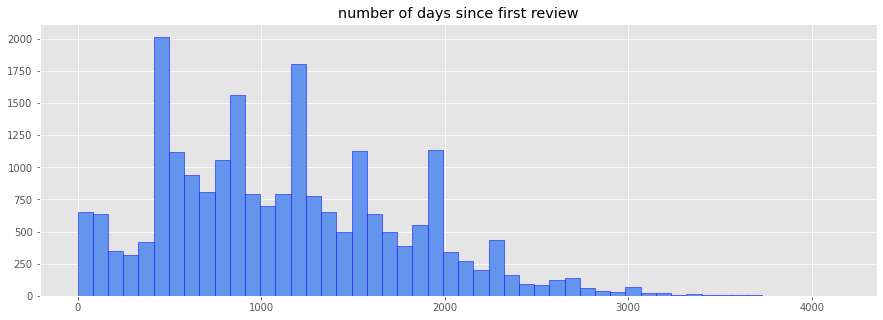

In [39]:
# Distribution of the number of days since first review
df_sydney_airbnb_listings.time_since_first_review.hist(figsize=(15,5), bins=50, color = "cornflowerblue", ec='blue')
plt.title('number of days since first review');

In [40]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df_sydney_airbnb_listings[col] = pd.cut(df_sydney_airbnb_listings[col], bins=bins, labels=labels, include_lowest=True)
    df_sydney_airbnb_listings[col] = df_sydney_airbnb_listings[col].astype('str')
    df_sydney_airbnb_listings[col].fillna(na_label, inplace=True)

In [41]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 365, 730, 1825, max(df_sydney_airbnb_listings.time_since_first_review)],
           labels=['0-1 year',
                   '1-2 years',
                   '2-5 years',
                   '5+ years'],
           na_label='no reviews')

Same process for `last_review`

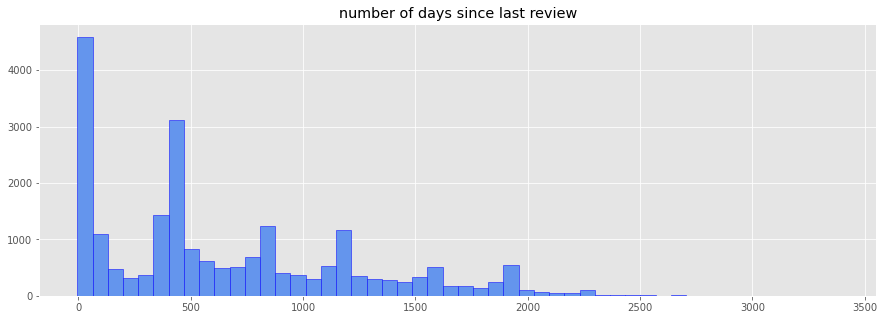

In [42]:
# Converting to datetime
df_sydney_airbnb_listings.last_review = pd.to_datetime(df_sydney_airbnb_listings.last_review) 

# Calculating the number of days between the most recent review and the date the data was scraped
df_sydney_airbnb_listings['time_since_last_review'] = (pd.datetime(2021, 4, 10) - df_sydney_airbnb_listings.last_review).astype('timedelta64[D]')

# Distribution of the number of days since last review
df_sydney_airbnb_listings.time_since_last_review.hist(figsize=(15,5), bins=50, color = "cornflowerblue", ec='blue')
plt.title('number of days since last review');

In [43]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 183, 365, 1095, max(df_sydney_airbnb_listings.time_since_last_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-3 years',
                   '3+ years'],
           na_label='no reviews')

In [44]:
# Dropping last_review - first_review will be kept for exploratory analysis and dropped later
df_sydney_airbnb_listings.drop('last_review', axis=1, inplace=True)

#### `review` ratings columns 

Listings without reviews will be kept and replaced with `0`. The histograms below will give an overview of the distribution of the different review ratings. The majority of ratings are 9 or 10 out of 10, as also seen in the value count below.

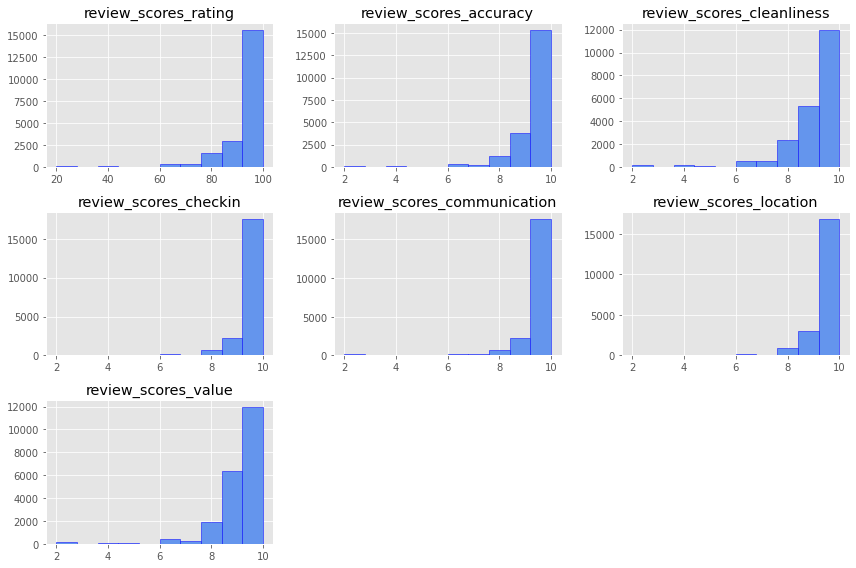

In [45]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df_sydney_airbnb_listings.columns[df_sydney_airbnb_listings.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df_sydney_airbnb_listings[var_name].hist(bins=10,ax=ax,color = "cornflowerblue", ec='blue')
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [46]:
# Filling the nan values of the listing review columns with zero
df_sydney_airbnb_listings.fillna( {
        'review_scores_rating': 0,
        'review_scores_accuracy': 0,
        'review_scores_cleanliness': 0,
        'review_scores_checkin': 0,
        'review_scores_communication': 0,
        'review_scores_location': 0,
        'review_scores_value': 0} , inplace=True)

#### `number_of_reviews_ltm` and `reviews_per_month`

These will be highly correlated with `number_of_reviews` and so  `number_of_reviews_ltm` and `reviews_per_month` will be dropped.

In [47]:
df_sydney_airbnb_listings.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

## Exploratory Data Analysis

#### Time Series

Time is an important factor to consider in a model when we wish to predict prices or trends. In response to business questions like: Is there any *seasonality* to the price? Is it *stationary*? So in this section, we will explore the time/seasonality of the dataset.

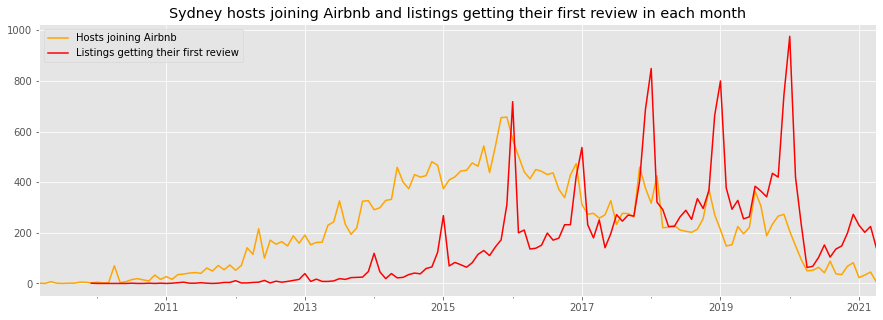

In [48]:
plt.figure(figsize=(15,5))
df_sydney_airbnb_listings.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
df_sydney_airbnb_listings.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='red')
plt.title('Sydney hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlabel('')
plt.ylabel('')
plt.show()

In [49]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(df_sydney_airbnb_listings.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df_sydney_airbnb_listings.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [50]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

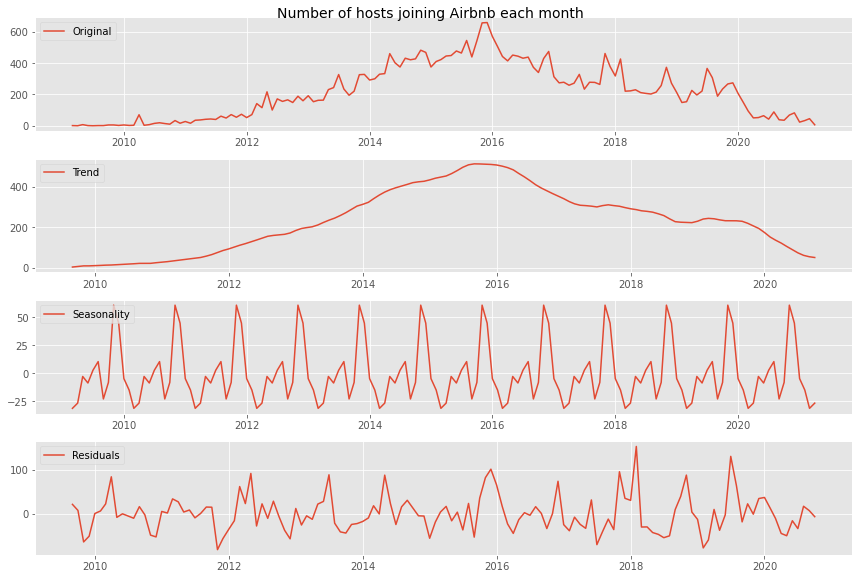

In [51]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

From the above plots we can see that there is a clear seasonality. Every year, we can observe a peak towards hosts joining around the year end during summer. Moreover, there is a second peak recorded in July, August during school holidays. The lowest points recorded just after the beginning of each year. There is a large peak in the number of hosts joining Airbnb in 2016.

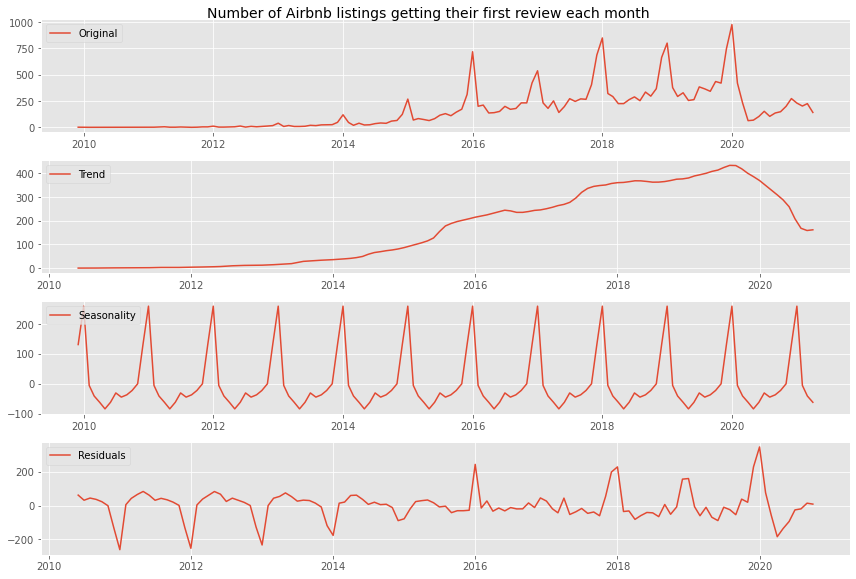

In [52]:
decompose_time_series(ts_first_review, title='Number of Airbnb listings getting their first review each month')

Visualising the change in the number of listings per host on Airbnb in Sydney over the years

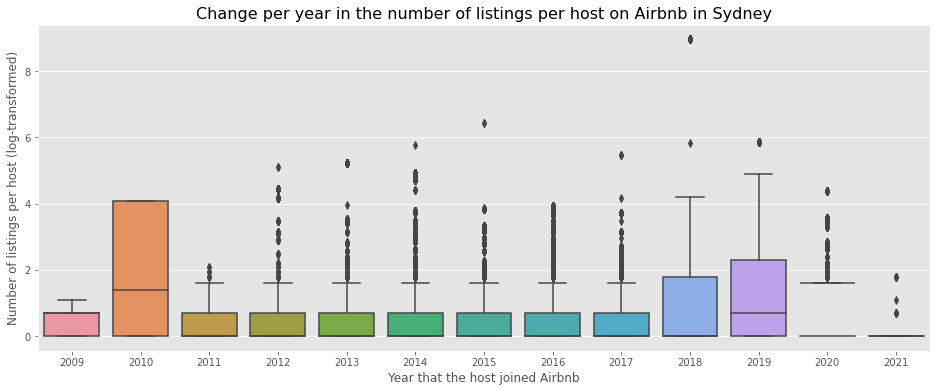

In [53]:
plt.figure(figsize=(16,6))
sns.boxplot(df_sydney_airbnb_listings.host_since.dt.year, np.log(df_sydney_airbnb_listings.host_listings_count))
plt.xlabel('Year that the host joined Airbnb', fontsize=12)
plt.ylabel('Number of listings per host (log-transformed)', fontsize=12)
plt.title('Change per year in the number of listings per host on Airbnb in Sydney', fontsize=16)
plt.show()

In [54]:
print("Average number of listings per host per year on Airbnb in Sydney:")
print(round(df_sydney_airbnb_listings.set_index('host_since').host_listings_count.resample('YS').mean(),2))

Average number of listings per host per year on Airbnb in Sydney:
host_since
2009-01-01      1.65
2010-01-01     21.81
2011-01-01      1.53
2012-01-01      7.92
2013-01-01      8.65
2014-01-01     10.15
2015-01-01      2.70
2016-01-01      3.49
2017-01-01      3.08
2018-01-01    610.98
2019-01-01     32.76
2020-01-01      5.92
2021-01-01      0.89
Freq: AS-JAN, Name: host_listings_count, dtype: float64


In [55]:
# List of the largest host_listings_count and the year the host joined Airbnb
df_sydney_airbnb_listings.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

,host_since,host_listings_count
32526,2019-01-08,133.0
12764,2014-05-19,138.0
17584,2012-01-24,164.0
26361,2013-07-10,185.0
15063,2017-07-05,239.0
18558,2014-11-24,317.0
31942,2018-06-08,338.0
25402,2019-07-24,354.0
28670,2015-11-12,615.0
31673,2018-02-24,7755.0


Visualising the change in the nightly price of Airbnb listings in Sydney over the years

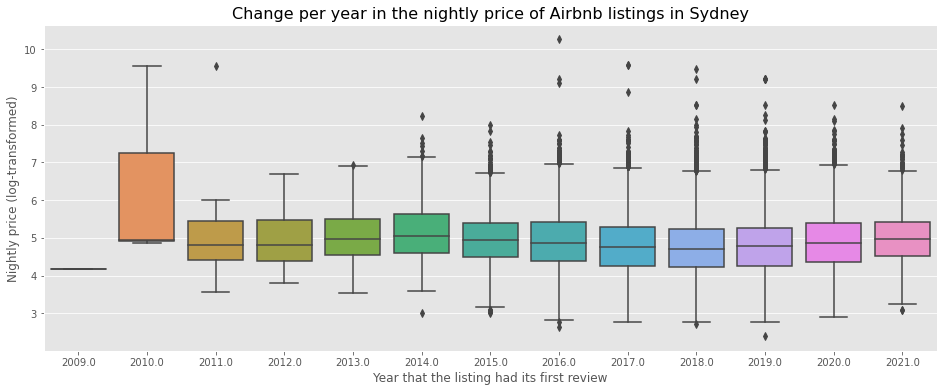

In [56]:
plt.figure(figsize=(16,6))
sns.boxplot(df_sydney_airbnb_listings.first_review.dt.year, np.log(df_sydney_airbnb_listings.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in Sydney', fontsize=16)
plt.show()

In [57]:
print("Mean nightly price of listings in each year on Airbnb in Sydney:")
print(round(df_sydney_airbnb_listings.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in Sydney:
first_review
2009-01-01      65.00
2010-01-01    4861.67
2011-01-01     753.75
2012-01-01     174.30
2013-01-01     201.81
2014-01-01     240.59
2015-01-01     200.25
2016-01-01     212.82
2017-01-01     190.74
2018-01-01     182.10
2019-01-01     191.20
2020-01-01     207.67
2021-01-01     219.59
Name: price, dtype: float64


In [58]:
# Dropping host_since and first_review as they are no longer needed
df_sydney_airbnb_listings.drop(['host_since', 'first_review'], axis=1, inplace=True)

#### Numerical Features

In [59]:
df_sydney_airbnb_listings.describe()

,id,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,...,white_goods,elevator,gym,parking,outdoor_space,heating,hot_tub_sauna_or_pool,internet,long_term_stays,private_entrance
count,3.170200e+04,31702.000000,31702.000000,31702.000000,31702.000000,31702.000000,31702.000000,31702.000000,31702.000000,31702.000000,...,31702.00000,31702.000000,31702.000000,31702.000000,31702.000000,31702.000000,31702.000000,31702.000000,31702.000000,31702.000000
mean,2.562335e+07,0.121538,67.954356,0.745915,3.257744,1.306858,1.623241,1.902057,223.368967,6.461138,...,0.91111,0.242918,0.106019,0.632326,0.185509,0.593054,0.215318,0.922024,0.779351,0.278973
std,1.339059e+07,0.326757,680.612307,0.435352,2.141305,0.716643,1.036692,1.479926,460.700136,32.837790,...,0.28459,0.428853,0.307866,0.482180,0.388716,0.491272,0.411049,0.268138,0.414690,0.448501
min,1.115600e+04,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,5.000000,1.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.510336e+07,0.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,74.000000,1.000000,...,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,2.431127e+07,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,122.000000,2.000000,...,1.00000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
75%,3.810998e+07,0.000000,2.000000,1.000000,4.000000,1.000000,2.000000,2.000000,220.000000,5.000000,...,1.00000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,4.912045e+07,1.000000,7755.000000,1.000000,16.000000,18.000000,46.000000,27.000000,28613.000000,1125.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


`price`

In [60]:
print(f"Advertised prices range from ${min(df_sydney_airbnb_listings.price)} to ${max(df_sydney_airbnb_listings.price)}.")

Advertised prices range from $5 to $28613.


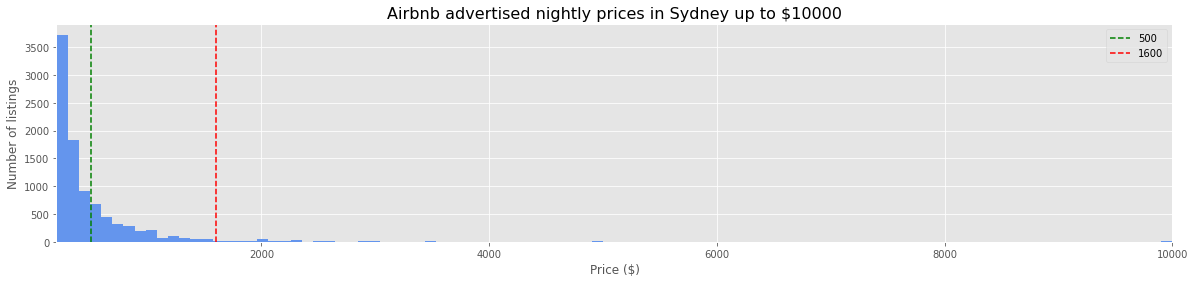

In [61]:
# Distribution of prices from $200 upwards
plt.figure(figsize=(20,4))
df_sydney_airbnb_listings.price.hist(bins=100, range=(200, 10000), color='cornflowerblue')
plt.margins(x=0)
plt.axvline(500, color='green', linestyle='--', label=500)
plt.axvline(1600, color='red', linestyle='--',label=1600)
plt.title("Airbnb advertised nightly prices in Sydney up to $10000", fontsize=16)
plt.legend()
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

In [62]:
# Replacing values over $5000 with $5000
df_sydney_airbnb_listings.loc[df_sydney_airbnb_listings.price >= 5000, 'price'] = 5000

`host_listings_count`

In [63]:
print("Median number of listings per host:", int(df_sydney_airbnb_listings.host_listings_count.median()))
print("Mean number of listings per host:", int(round(df_sydney_airbnb_listings.host_listings_count.mean())))
print("Highest number of listins per host:", int(round(df_sydney_airbnb_listings.host_listings_count.max())))
print(f"{int(round(100*len(df_sydney_airbnb_listings[df_sydney_airbnb_listings.host_listings_count == 1])/len(df_sydney_airbnb_listings)))}% of listings are from hosts with one listing.")

Median number of listings per host: 1
Mean number of listings per host: 68
Highest number of listins per host: 7755
54% of listings are from hosts with one listing.


The median number of listings that the host of each listing has is 1. This means that on average (median) each listing is hosted by a host who only manages that listing. The host with the highest number of listings has 7755 listings under its ID. 


`accommodates`, `bathrooms`, `bedrooms` and `beds`

Properties that accommodate more people achieve noticeably higher rates per night.

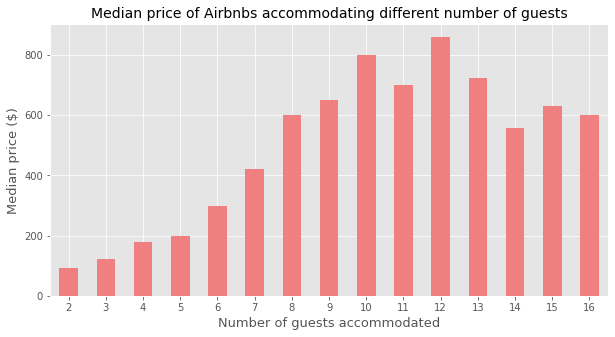

In [64]:
plt.figure(figsize=(10,5))
df_sydney_airbnb_listings.groupby('accommodates').price.median().plot(kind='bar', color='lightcoral')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price ($)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

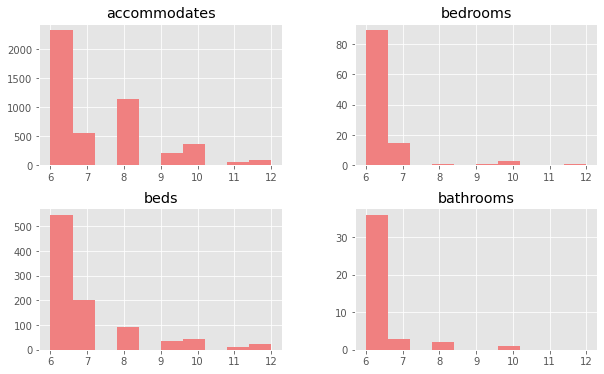

In [65]:
df_sydney_airbnb_listings[['accommodates', 'bedrooms', 'beds', 'bathrooms']].hist(range=[6, 12], figsize=(10,6), color='lightcoral');

#### Categorical Features

`Neighbourhood`

In [66]:
# This is the file ID of the data set
dataset_file_id = '1RZm0WD83mp2hG-Sv4yyexwma2yIZOxO7'

# Download the file from Google Drive
downloaded = drive.CreateFile({'id':dataset_file_id})
downloaded.GetContentFile('neighbourhoods.geojson')

In [67]:
# Renaming the neighbourhood column
data_file = 'neighbourhoods.geojson'
map_df = geopandas.read_file(data_file) # Reading the data to dataframes and storing as a dataframe
map_df.head()

,neighbourhood,neighbourhood_group,geometry
0,Pittwater,None,"MULTIPOLYGON (((151.29613 -33.57292, 151.29618..."
1,Randwick,None,"MULTIPOLYGON (((151.23722 -33.89075, 151.23731..."
2,Waverley,None,"MULTIPOLYGON (((151.28337 -33.86183, 151.28334..."
3,Warringah,None,"MULTIPOLYGON (((151.21140 -33.61521, 151.21157..."
4,Lane Cove,None,"MULTIPOLYGON (((151.16634 -33.80621, 151.16650..."


In [68]:
# Dropping the empty column of neighbourhood_group
map_df.drop('neighbourhood_group', axis=1, inplace=True)

# Creating a dataframe of listing counts and median price by borough
borough_df = pd.DataFrame(df_sydney_airbnb_listings.groupby('neighbourhood_cleansed').size())
borough_df.rename(columns={0: 'number_of_listings'}, inplace=True)
borough_df['median_price'] = df_sydney_airbnb_listings.groupby('neighbourhood_cleansed').price.median().values

# Joining the dataframes
borough_map_df = map_df.set_index('neighbourhood').join(borough_df)

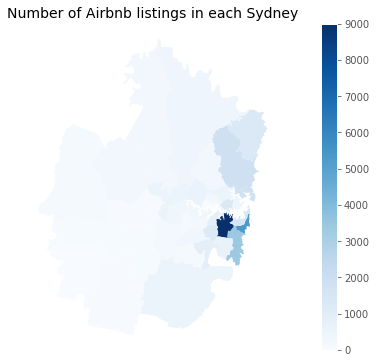

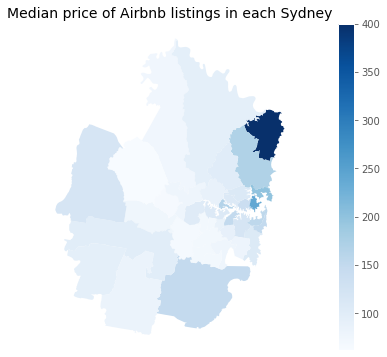

In [69]:
# Plotting the number of listings
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='number_of_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each Sydney', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='median_price', cmap='Blues', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each Sydney', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(borough_map_df.median_price), vmax=max(borough_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

`property_type` and `room_type` 

In [70]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    df_sydney_airbnb_listings[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=90)
    plt.show()

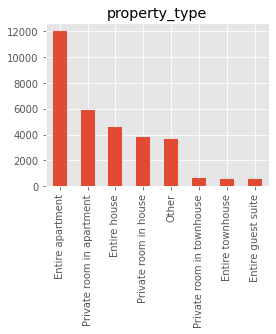

Entire apartment             0.378493
Private room in apartment    0.184973
Entire house                 0.144723
Private room in house        0.120813
Other                        0.115324
Private room in townhouse    0.021355
Entire townhouse             0.017507
Entire guest suite           0.016813
Name: property_type, dtype: float64


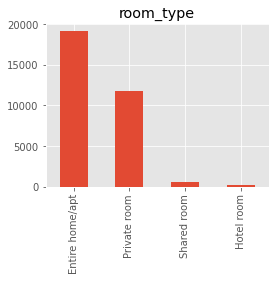

Entire home/apt    0.603905
Private room       0.370955
Shared room        0.017917
Hotel room         0.007224
Name: room_type, dtype: float64


In [71]:
for col in ['property_type', 'room_type']:
    category_count_plot(col, figsize=(4,3))
    print(df_sydney_airbnb_listings[col].value_counts(normalize=True))

`review` categories

For every review category, the majority of listings that have had a review have received a 10/10 rating for that category (or 95-100/100 overall). Guests seem to be most positive about communication, check-ins and accuracy. As noted previously, over a quarter of listings have not yet been reviewed.

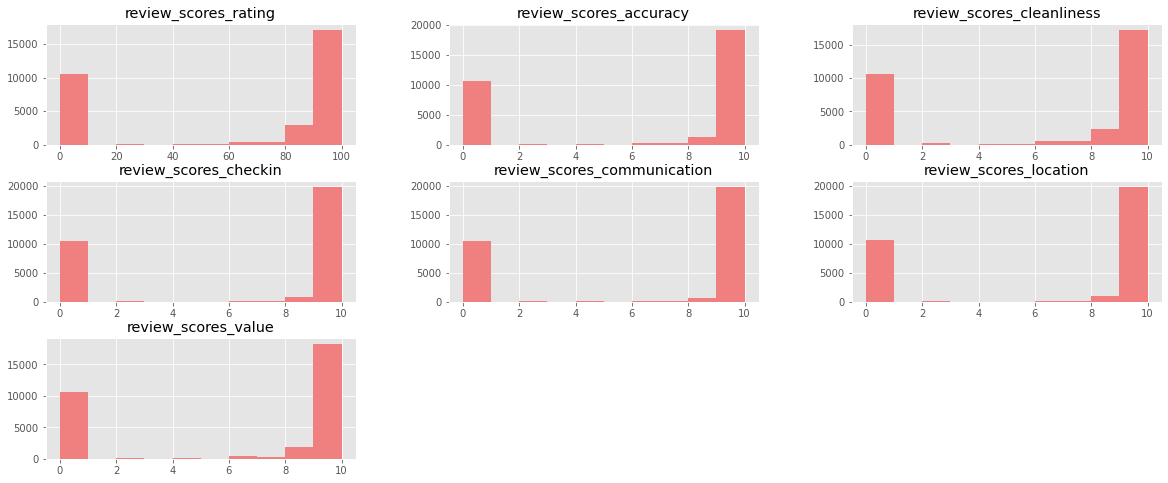

In [72]:
df_sydney_airbnb_listings[['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
                           'review_scores_communication','review_scores_location','review_scores_value']].hist(figsize=(20,8), color='lightcoral');

`first_review` and `last_review`

The most common time period in which currently live Airbnb listings had their first review is 2-3 years. This means that a lot of listings on the site have been active for at least a couple of years. Relatively few have been active for more than four years, however.

The most common category for the time since a listing received its last review is 1+ years. This means that a lot of listings have not been reviewed recently. The majority of these are probably what are sometimes referred to 'inactive' listings, because although they are technically live on the site, they do not have their calendards open and are not available to book.

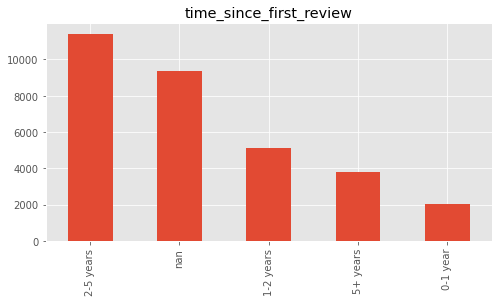

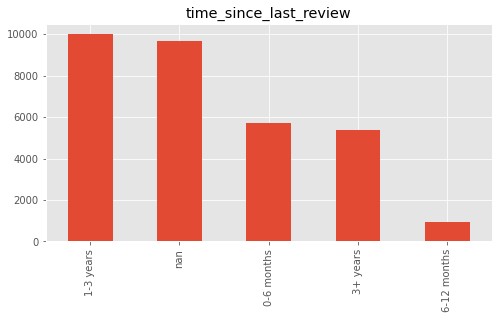

In [73]:
for col in ['time_since_first_review', 'time_since_last_review']:
    category_count_plot(col)

## Preparing data for building the AI models

#### Dropping columns and assessing multi-collinearity

In [74]:
# Make a copy of the original dataframe
NEW_df_sydney_listings = df_sydney_airbnb_listings.copy()

# Drop columns
# df_sydney_airbnb_listings.drop(['id','name','neighbourhood','neighbourhood_cleansed'], axis=1, inplace=True)
NEW_df_sydney_listings.drop(['id','name','neighbourhood','time_since_first_review','time_since_first_review'], axis=1, inplace=True)

In [75]:
# one-hot encoding to transform the categorical into numerical variables while preserving their relationship with the output variable. 
transformed_df = pd.get_dummies(NEW_df_sydney_listings)
transformed_df.head()

,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,...,property_type_Private room in townhouse,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,time_since_last_review_0-6 months,time_since_last_review_1-3 years,time_since_last_review_3+ years,time_since_last_review_6-12 months,time_since_last_review_nan
0,0.0,1.0,0.0,1,1.0,1.0,0.0,65,2,180,...,0,0,0,1,0,0,1,0,0,0
1,0.0,2.0,1.0,2,1.0,1.0,1.0,5000,2,7,...,1,0,0,1,0,0,1,0,0,0
2,1.0,2.0,1.0,6,3.0,3.0,3.0,470,5,22,...,0,1,0,0,0,0,1,0,0,0
3,0.0,3.0,1.0,2,1.0,1.0,1.0,80,2,90,...,0,0,0,1,0,1,0,0,0,0
4,1.0,1.0,1.0,2,1.0,1.0,1.0,130,3,365,...,0,1,0,0,0,0,1,0,0,0


In [76]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

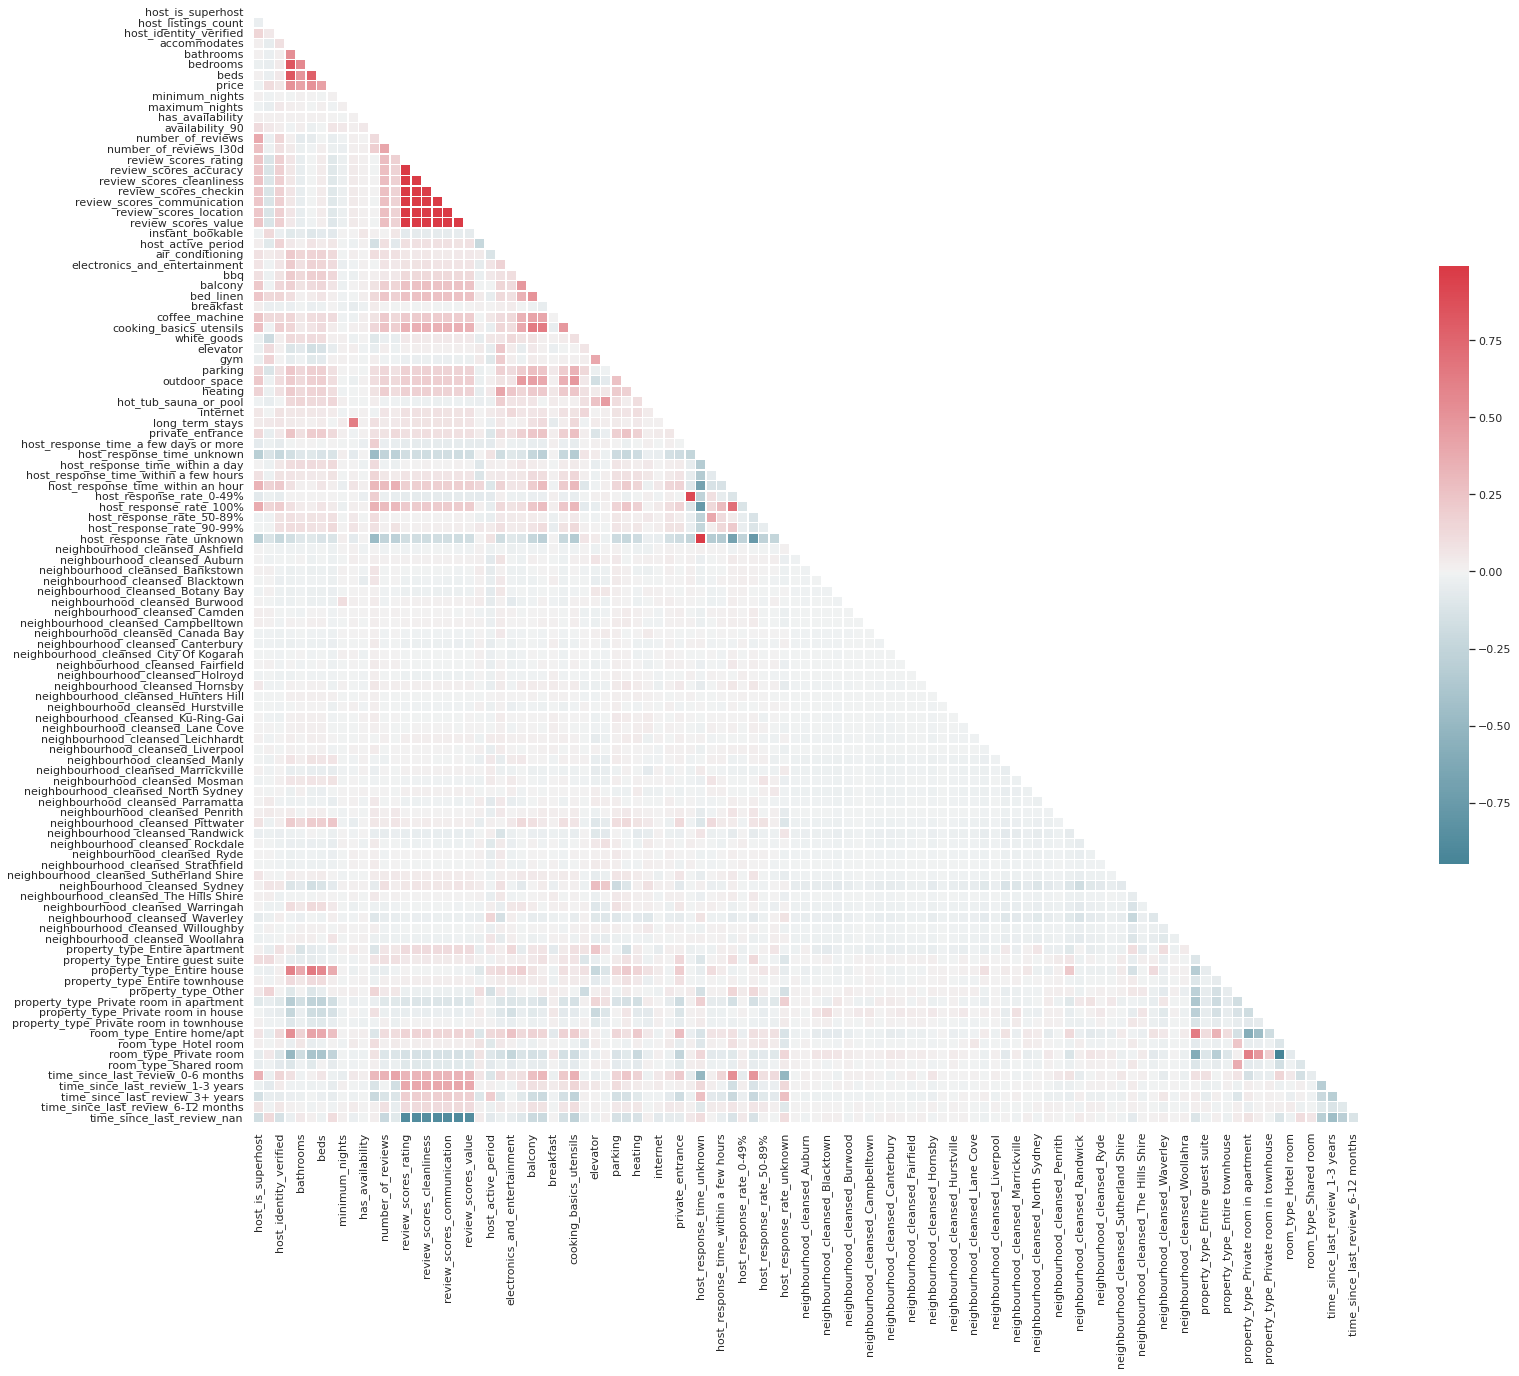

In [77]:
# plotting the correlation matrix
multi_collinearity_heatmap(transformed_df, figsize=(25,22))

In [78]:
# Dropping multicollinear features
to_drop = ['beds','host_response_rate_0-49%','room_type_Private room','review_scores_accuracy','review_scores_cleanliness',
           'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location']
# Dropping features ending with 'nan' and 'unknown'
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('unknown')]))
transformed_df.drop(to_drop, axis=1, inplace=True)

In [79]:
numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'host_days_active', 'host_listings_count', 
                     'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price']

# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']]
for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

## Building the Models

Now that a significant data preprocessing phase is done, we can start building the predictive model using , **XGBoost** and **Light GBM** supervised machine learning algorithms.

In [80]:
# Here we use a different function (from the numpy library) to randomly split the dataset into test/training/validation 
train, test, validate = np.split(transformed_df.sample(frac=1), [int(.8*len(transformed_df)), int(.9*len(transformed_df))]) # 80%, 10%, 10%
# train, test, validate = np.split(transformed_df.sample(frac=1), [int(.6*len(transformed_df)), int(.8*len(transformed_df))]) # 60%, 20%, 20%

print (train.shape, test.shape, validate.shape)

(25361, 95) (3170, 95) (3171, 95)


In [81]:
# Perparing data for prediction, by defining the predictor variables and the target variables
X_train = train.drop(columns=['price'])
y_train = train[['price']]

X_test = test.drop(columns=['price'])
y_test = test[['price']]

X_validate = validate.drop(columns=['price'])
y_validate = validate[['price']]

In [82]:
# XGBoost 
priceXGB = xgb.XGBRegressor() 
priceXGB.fit(X_train,y_train)

[03:19:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [83]:
# LightGBM
priceLightGBM = lgb.LGBMRegressor(objective='regression', learning_rate=0.01, max_depth=12, n_estimators=120)
priceLightGBM.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.01, max_depth=12, n_estimators=120,
              objective='regression')

## Model Evaluation

As this is a regression problem (where we are predicting a continuous numerical variable - price), we use *Mean Absolute Error*, *Mean Squared Error*, *Median Absolute Error*, *Variance* and *R2 score* as evaluation metrics.

In [84]:
# Evaluating the performance metrics
regressors = [priceXGB, priceLightGBM]
evalTable = PrettyTable(['Name', 'R-squared', 'MAE', 'RMSE', 'MedAE'], sortby='RMSE')
for i in regressors:
  # predict emissions
  y_predict = i.predict(X_test)
  evalTable.add_row( [ type(i).__name__, 
                      (round(i.score(X_test, y_test),3)), 
                      round(metrics.mean_absolute_error(y_test, y_predict),3),
                      round(metrics.mean_squared_error(y_test, y_predict, squared=False),3),
                      round(metrics.median_absolute_error(y_test, y_predict),3),
                    ] )
print(evalTable)

+---------------+-----------+-------+-------+-------+
|      Name     | R-squared |  MAE  |  RMSE | MedAE |
+---------------+-----------+-------+-------+-------+
|  XGBRegressor |   0.714   | 0.344 | 0.466 | 0.273 |
| LGBMRegressor |   0.609   | 0.415 | 0.545 | 0.336 |
+---------------+-----------+-------+-------+-------+


### Fine-tuning the LightGBM model

In the above evaluation metrics we notice that the XGBRegressor has performed better than the LGBMRegressor. Also recall, we used the default parameters for both models. 
Now let's explore if we can fine-tune the parameters of the LGBMRegressor. As this is a tree based algorithm, we can start by fine-tuning tree depth and number of trees. Grid search is a well known approach to search for optimized parameters from given set of values for each tunable parameter. In the following segment, we search for optimal parameters for the LGBMRegressor.

In [85]:
parameters = {
    'n_estimators': [120, 200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [10, 12],
}

eval_set = [(X_train, y_train), (X_validate, y_validate)]
model = lgb.LGBMRegressor(eval_set=eval_set, objective='regression', verbose=0)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 200}
Best validation score = 0.7347727641836321


In [86]:
best_priceLGBM = lgb.LGBMRegressor(**clf.best_params_, objective='regression')
best_priceLGBM.fit(X_train, y_train, eval_set=eval_set, verbose=False)
y_test_pred = best_priceLGBM.predict(X_test)

In [87]:
print("MAE =", round(metrics.mean_absolute_error(y_test, y_test_pred), 2)) 
print("RMSE =", round(metrics.mean_squared_error(y_test, y_test_pred), 2)) 
print("MedAE =", round(metrics.median_absolute_error(y_test, y_test_pred), 2)) 
print("Explain variance score =", round(metrics.explained_variance_score(y_test, y_test_pred), 2)) 
print("R-squared =", round(metrics.r2_score(y_test, y_test_pred), 2))

MAE = 0.32
RMSE = 0.19
MedAE = 0.25
Explain variance score = 0.75
R-squared = 0.75


Notice how fine-tuning has further improved the LGBMRegressor model. The same can be attempted for the XBGRegressor. Refer to the scikit learn documentation for which parameters are most sensitive and how to fine-tune these. 

## Model Explainability

We can use the built-in "feature_importance" function in XGB to explain how the AI model predicts price based on the importance of the input features. 

In [88]:
# Extracting the feature importance of the priceXGB model
ft_weights_xgb_reg = pd.DataFrame(priceXGB.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
# extracting the top 30 features
ft_weights_xgb_reg = ft_weights_xgb_reg.tail(30) 

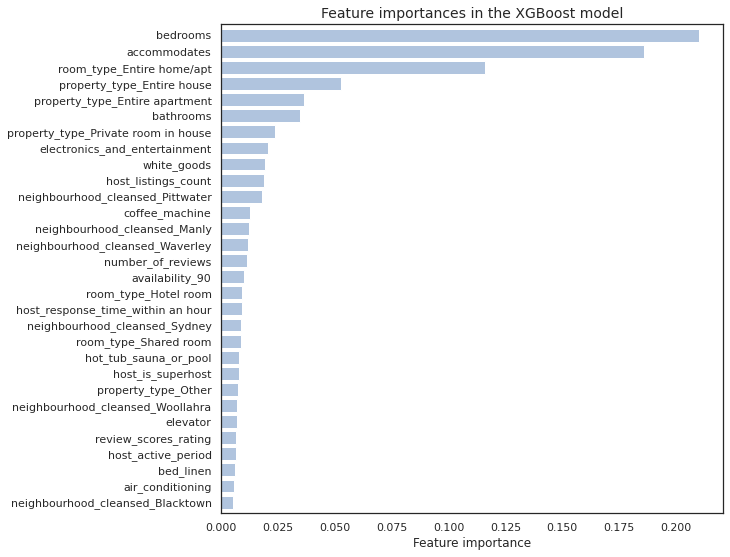

In [89]:
# Plotting the top 30 important features of the priceXGB model
plt.figure(figsize=(9,9))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center', color='lightsteelblue') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()